In [9]:
import os
import subprocess
import re

In [29]:
cwd=os.getcwd()
cwd

'/home/yifan/dev/src/gitlab.com/syifan/rccl_example'

In [22]:
timeRe = re.compile(r'^Time: ([0-9]+)$')

In [80]:
def measure_time(buf_size):
    process = subprocess.run(
        "./multigpu_rccl", 
        shell=True, check=True, 
        capture_output=True, text=True, 
        env={"NCCL_BUFFSIZE": str(buf_size)},
        )
    output = process.stdout.split('\n')

    time = 0
    for l in output:
        match = timeRe.match(l)
        if match != None:
            time_str = match.group(1)
            time = int(time_str)

    return time

In [78]:
def profile(buf_size):
    try:
        process = subprocess.run(
            "/opt/rocm/bin/rocprof -i metric_spec.txt multigpu_rccl", 
            shell=True, 
            capture_output=True, text=True,
            cwd=cwd,
            
            )
        print(process.stdout)
    except Exception as e:
        print(process.stdout)
        print(process.stderr)
        print(e)
        raise e

    profile_data = pd.read_csv('metric_spec.csv')
    profile_data

    sum = profile_data.sum()
    fetch_size = sum['FetchSize']
    write_size = sum['WriteSize']

    return (fetch_size, write_size)

In [82]:
def measure(buf_size):
    time = measure_time(buf_size)
    fetch_size, write_size = profile(buf_size)
    return {"time": time, "fetch_size": fetch_size, "write_size": write_size}

In [83]:
measure(128)


RPL: on '210611_093431' from '/opt/rocm-4.2.0/rocprofiler' in '/home/yifan/dev/src/gitlab.com/syifan/rccl_example'
RPL: profiling '"multigpu_rccl"'
RPL: input file 'metric_spec.txt'
RPL: output dir '/tmp/rpl_data_210611_093431_36032'
RPL: result dir '/tmp/rpl_data_210611_093431_36032/input0_results_210611_093431'
ROCProfiler: input from "/tmp/rpl_data_210611_093431_36032/input0.xml"
  gpu_index = 
  kernel = 
  range = 
  1 metrics
    FetchSize
  0 traces
Time: 11221954217
5.000000, 5.000000, 5.000000, 5.000000, 5.000000, 5.000000, 5.000000, 5.000000, 
Success 

ROCPRofiler: 100 contexts collected, output directory /tmp/rpl_data_210611_093431_36032/input0_results_210611_093431
RPL: result dir '/tmp/rpl_data_210611_093431_36032/input1_results_210611_093431'
ROCProfiler: input from "/tmp/rpl_data_210611_093431_36032/input1.xml"
  gpu_index = 
  kernel = 
  range = 
  1 metrics
    WriteSize
  0 traces
Time: 11170185686
5.000000, 5.000000, 5.000000, 5.000000, 5.000000, 5.000000, 5.000000

{'time': 11189304669, 'fetch_size': 87893765, 'write_size': 85708766}

In [88]:
import pandas as pd

sizes = [128, 256, 512, 1024, 2048, 4096, 8192, 16384]
repeat = 2

data = pd.DataFrame()

for s in sizes:
    for r in range(repeat):
        result = measure(s)
        result["size"] = s
        data = data.append(result, ignore_index=True)

pd.to_csv('data.csv')


RPL: on '210611_094611' from '/opt/rocm-4.2.0/rocprofiler' in '/home/yifan/dev/src/gitlab.com/syifan/rccl_example'
RPL: profiling '"multigpu_rccl"'
RPL: input file 'metric_spec.txt'
RPL: output dir '/tmp/rpl_data_210611_094611_43478'
RPL: result dir '/tmp/rpl_data_210611_094611_43478/input0_results_210611_094611'
ROCProfiler: input from "/tmp/rpl_data_210611_094611_43478/input0.xml"
  gpu_index = 
  kernel = 
  range = 
  1 metrics
    FetchSize
  0 traces
Time: 11249895263
5.000000, 5.000000, 5.000000, 5.000000, 5.000000, 5.000000, 5.000000, 5.000000, 
Success 

ROCPRofiler: 100 contexts collected, output directory /tmp/rpl_data_210611_094611_43478/input0_results_210611_094611
RPL: result dir '/tmp/rpl_data_210611_094611_43478/input1_results_210611_094611'
ROCProfiler: input from "/tmp/rpl_data_210611_094611_43478/input1.xml"
  gpu_index = 
  kernel = 
  range = 
  1 metrics
    WriteSize
  0 traces
Time: 11177543794
5.000000, 5.000000, 5.000000, 5.000000, 5.000000, 5.000000, 5.000000

AttributeError: module 'pandas' has no attribute 'to_csv'

In [89]:
data

fetch_size     size          time  write_size
0   87900329.0    128.0  1.122417e+10  85877716.0
1   87993235.0    128.0  1.123682e+10  84617586.0
2   46253129.0    256.0  5.691163e+09  44704166.0
3   44886420.0    256.0  5.681036e+09  44746672.0
4   24043394.0    512.0  2.911552e+09  23788143.0
5   24005316.0    512.0  2.895188e+09  25195250.0
6   13534704.0   1024.0  1.527510e+09  13622659.0
7   13498987.0   1024.0  1.521084e+09  13600646.0
8    8358309.0   2048.0  8.328072e+08   8406970.0
9    8322500.0   2048.0  8.243912e+08   8460978.0
10   4347615.0   4096.0  4.789069e+08   4517624.0
11   4347981.0   4096.0  4.789734e+08   4517624.0
12   4272403.0   8192.0  3.047785e+08   4479224.0
13   4271800.0   8192.0  3.055682e+08   4479224.0
14   4236304.0  16384.0  2.195784e+08   4460024.0
15   4237497.0  16384.0  2.199861e+08   4460024.0

In [98]:
plot_data = data.copy()
plot_data = plot_data.melt(id_vars=['size']).reset_index()
plot_data

index     size    variable         value
0       0    128.0  fetch_size  8.790033e+07
1       1    128.0  fetch_size  8.799324e+07
2       2    256.0  fetch_size  4.625313e+07
3       3    256.0  fetch_size  4.488642e+07
4       4    512.0  fetch_size  2.404339e+07
5       5    512.0  fetch_size  2.400532e+07
6       6   1024.0  fetch_size  1.353470e+07
7       7   1024.0  fetch_size  1.349899e+07
8       8   2048.0  fetch_size  8.358309e+06
9       9   2048.0  fetch_size  8.322500e+06
10     10   4096.0  fetch_size  4.347615e+06
11     11   4096.0  fetch_size  4.347981e+06
12     12   8192.0  fetch_size  4.272403e+06
13     13   8192.0  fetch_size  4.271800e+06
14     14  16384.0  fetch_size  4.236304e+06
15     15  16384.0  fetch_size  4.237497e+06
16     16    128.0        time  1.122417e+10
17     17    128.0        time  1.123682e+10
18     18    256.0        time  5.691163e+09
19     19    256.0        time  5.681036e+09
20     20    512.0        time  2.911552e+09
21     21    512.0        time  2.895188e+09
22     22   1024.0        time  1.527510e+09
23     23   1024.0        time  1.521084e+09
24     24   2048.0        time  8.328072e+08
25     25   2048.0        time  8.243912e+08
26     26   4096.0        time  4.789069e+08
27     27   4096.0        time  4.789734e+08
28     28   8192.0        time  3.047785e+08
29     29   8192.0        time  3.055682e+08
30     30  16384.0        time  2.195784e+08
31     31  16384.0        time  2.199861e+08
32     32    128.0  write_size  8.587772e+07
33     33    128.0  write_size  8.461759e+07
34     34    256.0  write_size  4.470417e+07
35     35    256.0  write_size  4.474667e+07
36     36    512.0  write_size  2.378814e+07
37     37    512.0  write_size  2.519525e+07
38     38   1024.0  write_size  1.362266e+07
39     39   1024.0  write_size  1.360065e+07
40     40   2048.0  write_size  8.406970e+06
41     41   2048.0  write_size  8.460978e+06
42     42   4096.0  write_size  4.517624e+06
43     43   4096.0  write_size  4.517624e+06
44     44   8192.0  write_size  4.479224e+06
45     45   8192.0  write_size  4.479224e+06
46     46  16384.0  write_size  4.460024e+06
47     47  16384.0  write_size  4.460024e+06

In [111]:
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt
import seaborn as sns

rc('text', usetex=False)
sns.set_context('paper', font_scale=2.0)
sns.set_style('whitegrid')

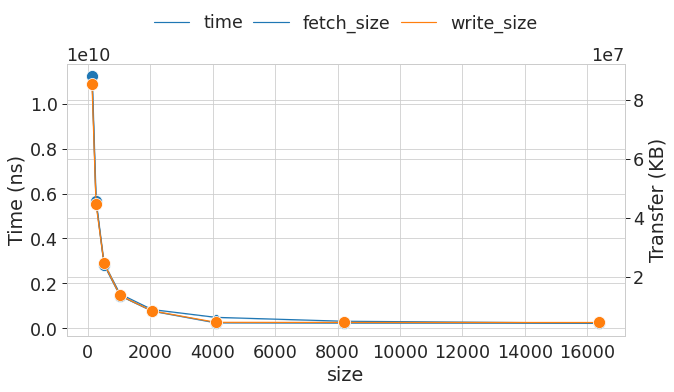

In [126]:
fig, ax1 = plt.subplots(figsize=[10, 5])
ax2 = ax1.twinx()

sns.lineplot(data=plot_data[plot_data['variable']=='time'], 
    x='size', y='value', hue='variable', 
    marker='o', markersize=6,
    ax=ax1)
ax1.set_ylabel('Time (ns)')

sns.lineplot(data=plot_data[plot_data['variable']!='time'], 
    x='size', y='value', hue='variable', 
    marker='o', markersize=12,
    ax=ax2)
ax2.set_ylabel('Transfer (KB)')

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, 
          frameon=False,
          fancybox=None, 
          columnspacing=0.6,
          facecolor=None, edgecolor=None, 
          bbox_to_anchor=(0.5, 1.15), 
          loc=10, ncol=4)
ax2.legend([],[], frameon=False)